In [3]:
import helpFunctions as hf 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imread
import scipy as sp
import os

## 0. Load Data

In [23]:
# Folder where data files are placed
dirIn = "./data/"

matFile = os.path.join(dirIn, 'multispectral_day01.mat')
annFile = os.path.join(dirIn, 'annotation_day01.png')

# Load multispectral images and annotations using original helpFunctions
multiIm, annotationIm = hf.loadMulti(matFile, annFile)

# The function getPix extracts the multi-spectral pixels from the annotations
[fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
[meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);

# Load non-annotated pixels to be classified
[bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

## 1. Threshold Value for a Single Spectral Band (Model 1)

In [24]:
mean_fat = np.mean(fatPix,0)
mean_meat = np.mean(meatPix,0)

t_list = []
errors = []

for i in range(19):
    t = (mean_fat[i] + mean_meat[i])/2
    t_list.append(t)

    n_fat = fatPix.shape[0]
    n_meat = meatPix.shape[0]

    fat_errors = np.sum(fatPix[:, i] < t)
    meat_errors = np.sum(meatPix[:, i] >= t)

    error = (fat_errors + meat_errors) / (n_fat + n_meat)
    errors.append(error)
    print(f"Spectral Band: {i+1}, t = {t}, error = {error}")

min_error = np.min(errors)
index = errors.index(min_error)
print(f"Spectral Band (best disc. properties): {index+1}, t = {t_list[index]: .3}, error = {min_error: .3}")

Spectral Band: 1, t = 23.79845037430177, error = 0.010434782608695653
Spectral Band: 2, t = 17.061514079315938, error = 0.016231884057971015
Spectral Band: 3, t = 25.00177322390945, error = 0.01217391304347826
Spectral Band: 4, t = 27.411072616180974, error = 0.008695652173913044
Spectral Band: 5, t = 29.717764591216604, error = 0.008115942028985508
Spectral Band: 6, t = 30.97639933166249, error = 0.008695652173913044
Spectral Band: 7, t = 29.99817763362655, error = 0.007536231884057971
Spectral Band: 8, t = 32.00265983586417, error = 0.010434782608695653
Spectral Band: 9, t = 49.85284289154258, error = 0.008115942028985508
Spectral Band: 10, t = 55.161459613085, error = 0.010434782608695653
Spectral Band: 11, t = 58.90757940603142, error = 0.005797101449275362
Spectral Band: 12, t = 64.41891698199747, error = 0.0052173913043478265
Spectral Band: 13, t = 69.17798786181139, error = 0.011014492753623189
Spectral Band: 14, t = 68.9655142758858, error = 0.00463768115942029
Spectral Band: 1

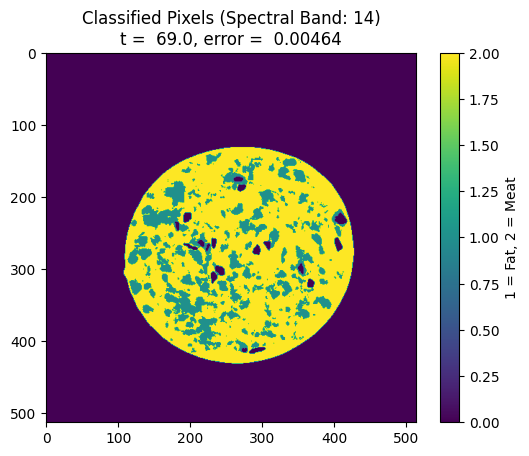

In [25]:
bgPix_14 = bgPix[:, index] # pixels spectral band 14

# 1 = fat, 2 = meat
classified = np.zeros(annotationIm.shape[:2], dtype=np.uint8)

for i in range(bgPix_14.shape[0]):
    r = bgR[i]
    c = bgC[i]

    if bgPix_14[i] > t_list[index]:
        classified[r, c] = 1  # fat
    else:
        classified[r, c] = 2  # meat


plt.imshow(classified)
plt.title(f"Classified Pixels (Spectral Band: {index+1})\nt = {t_list[index]: .3}, error = {min_error: .3}")
plt.colorbar(label="1 = Fat, 2 = Meat")
plt.show()

## 2. Classification by Means of all Spectral Bands (Model 2)

In [26]:
# Covariance
cov_fat = np.cov(fatPix, rowvar=False)
cov_meat = np.cov(meatPix, rowvar=False)

# Number of fat and meat pixels
nf = np.shape(fatPix)[0]
nm = np.shape(meatPix)[0]

# Pooled Covariance - equation 20
pooled_cov = ((nf-1)*cov_fat + (nm-1)*cov_meat)/((nf-1)+(nm-1))

# Discriminant Function - equation 23
p_fat = nf / (nf + nm)
p_meat = nm / (nf + nm)
cov_inv = np.linalg.inv(pooled_cov)

def Discriminant(x,i): 
    if i == 1: # if fat 
        return x @ cov_inv @ mean_fat - 0.5 * mean_fat  @ cov_inv @ mean_fat  + np.log(p_fat)
    if i == 2: # if meat 
        return x @ cov_inv @ mean_meat - 0.5 * mean_meat @ cov_inv @ mean_meat + np.log(p_meat)

def Classify(x):
    S_fat = Discriminant(x, 1)
    S_meat = Discriminant(x, 2)
    if S_fat > S_meat:
        return 1 # fat
    else:
        return 2 # meat
    
for i in range(bgPix.shape[0]):
    r = bgR[i]
    c = bgC[i]
    classified[r, c] = Classify(bgPix[i])

fat_errors_1 = np.sum(Discriminant(fatPix,1) < Discriminant(fatPix,2))
meat_errors_1 = np.sum(Discriminant(meatPix,2) < Discriminant(meatPix,1))
error_1 = (fat_errors_1+meat_errors_1)/(nf+nm)
print(f"Error (diss. betwen model/annotations): {error_1:.3}")

Error (diss. betwen model/annotations): 0.0058


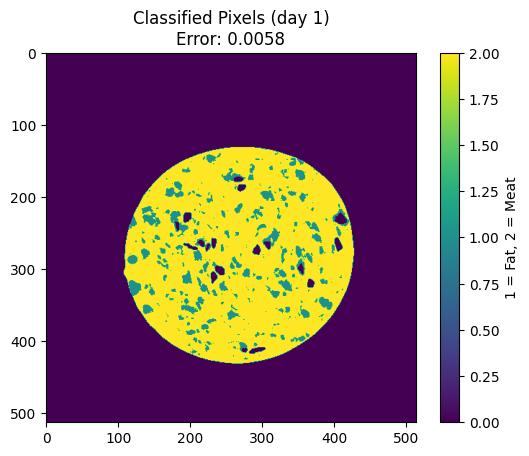

In [27]:
plt.imshow(classified)
plt.title(f"Classified Pixels (day 1)\nError: {error_1:.3}")
plt.colorbar(label="1 = Fat, 2 = Meat")
plt.show()

## 3. Calculation for all Days

#### (a) Model 1 - Spectral Band 14

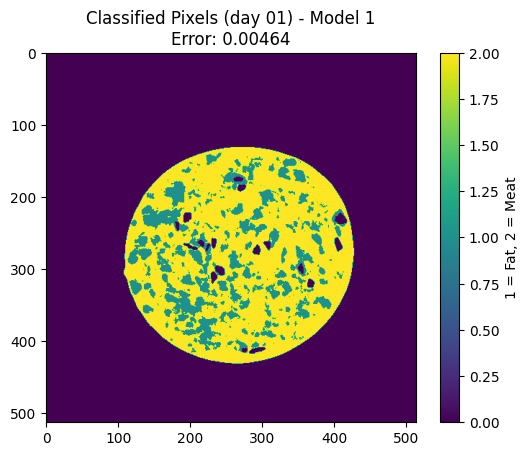

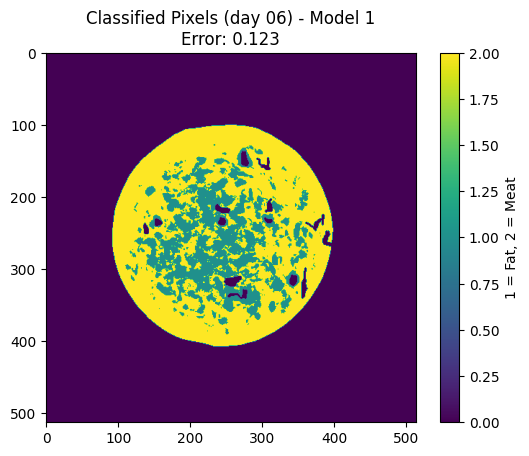

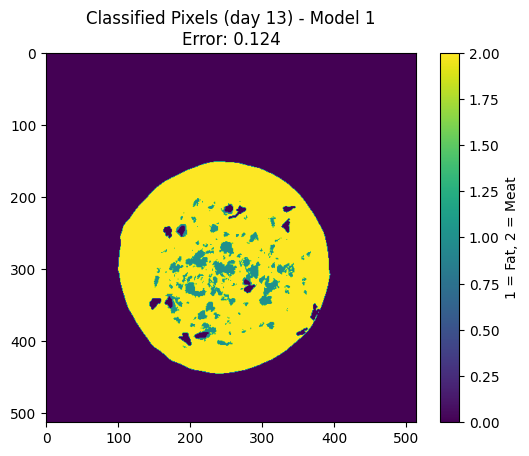

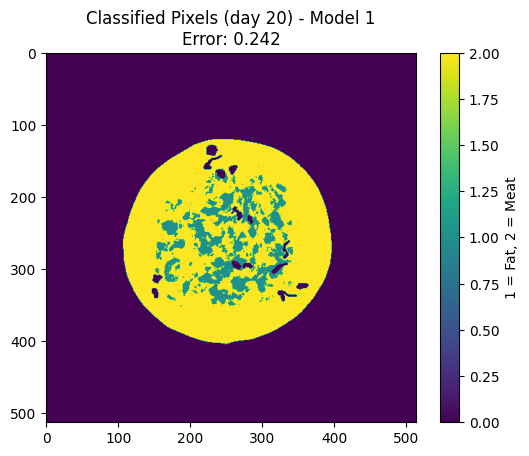

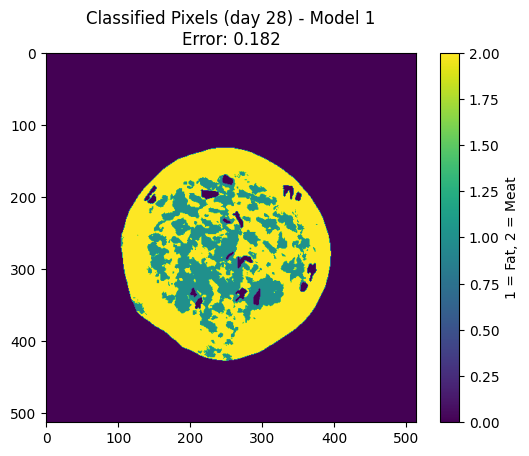

In [28]:
days = ["01", "06", "13", "20", "28"]
errors_model_1 = []

for day in days:
    # Loading data
    matFile = os.path.join(dirIn, f'multispectral_day{day}.mat')
    annFile = os.path.join(dirIn, f'annotation_day{day}.png')
    multiIm, annotationIm = hf.loadMulti(matFile, annFile)

    [fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
    [meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);
    [bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

    # Classify data based on Day 1 model (only spectral band 14 taken into account)
    bgPix_14 = bgPix[:, index]
    classified = np.zeros(annotationIm.shape[:2], dtype=np.uint8) # 1 = fat, 2 = meat

    for i in range(bgPix_14.shape[0]):
        r = bgR[i]
        c = bgC[i]

        if bgPix_14[i] > t_list[index]:
            classified[r, c] = 1  # fat
        else:
            classified[r, c] = 2  # meat

    # Estimate error between classified and annotated data
    n_fat = fatPix.shape[0]
    n_meat = meatPix.shape[0]

    fat_errors = np.sum(fatPix[:, index] < t_list[index])
    meat_errors = np.sum(meatPix[:, index] >= t_list[index])

    error = (fat_errors + meat_errors) / (n_fat + n_meat)
    errors_model_1.append(error)

    # Image
    plt.imshow(classified)
    plt.title(f"Classified Pixels (day {day}) - Model 1\nError: {error:.3}")
    plt.colorbar(label="1 = Fat, 2 = Meat")
    plt.show()


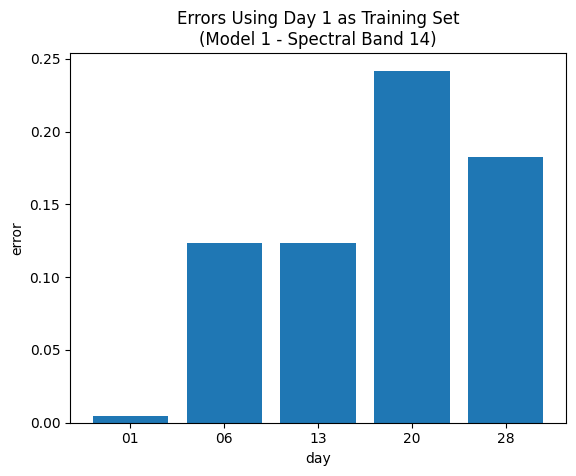

In [29]:
plt.bar(days, errors_model_1)
plt.title(f"Errors Using Day 1 as Training Set\n(Model 1 - Spectral Band 14)")
plt.xlabel("day")
plt.ylabel("error")
plt.show()

#### Model 2 - All Spectral Bands Model

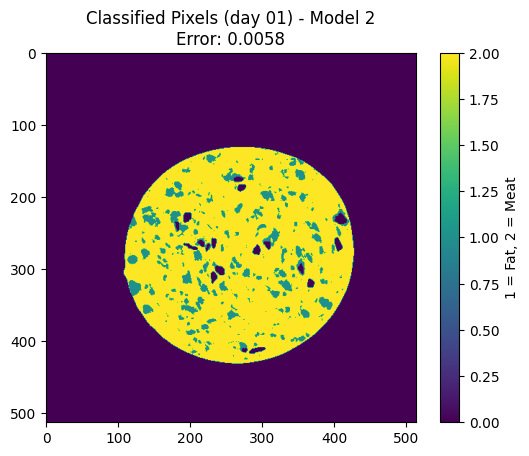

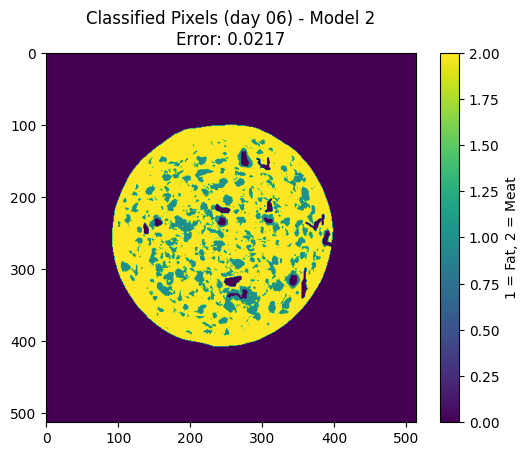

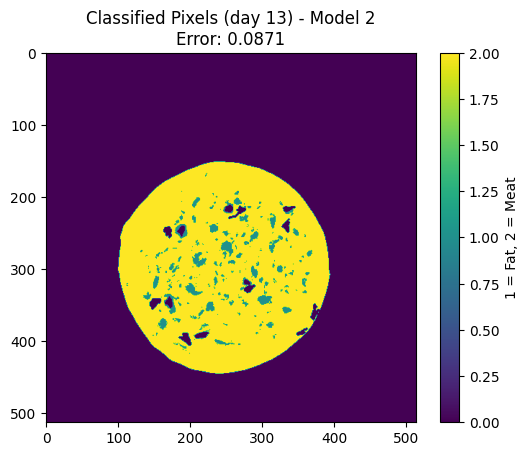

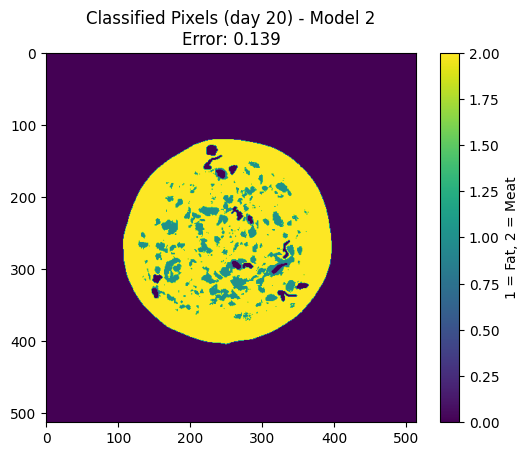

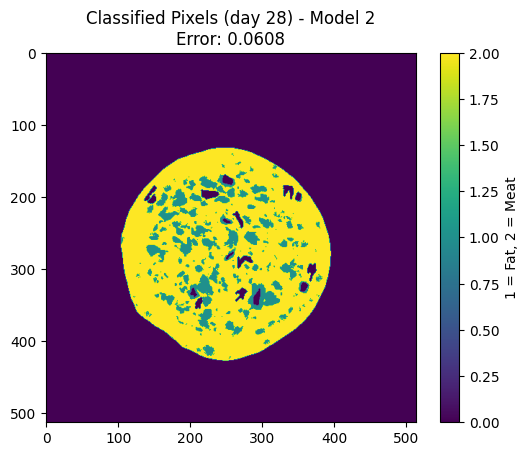

In [30]:
errors_model_2 = []

for day in days:
    # Loading data
    matFile = os.path.join(dirIn, f'multispectral_day{day}.mat')
    annFile = os.path.join(dirIn, f'annotation_day{day}.png')
    multiIm, annotationIm = hf.loadMulti(matFile, annFile)

    [fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
    [meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);
    [bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

    # Classify data based on Day 1 model
    classified = np.zeros(annotationIm.shape[:2], dtype=int)
    for i in range(bgPix.shape[0]):
        r = bgR[i]
        c = bgC[i]
        classified[r, c] = Classify(bgPix[i])

    # Estimate error between classified and annotated data
    nf_day = fatPix.shape[0]
    nm_day = meatPix.shape[0]
    fat_errors = np.sum(Discriminant(fatPix,1) < Discriminant(fatPix,2))
    meat_errors = np.sum(Discriminant(meatPix,2) < Discriminant(meatPix,1))
    error = (fat_errors + meat_errors) / (nf_day + nm_day)
    errors_model_2.append(error)

    # Image
    plt.imshow(classified)
    plt.title(f"Classified Pixels (day {day}) - Model 2\nError: {error:.3}")
    plt.colorbar(label="1 = Fat, 2 = Meat")
    plt.show()

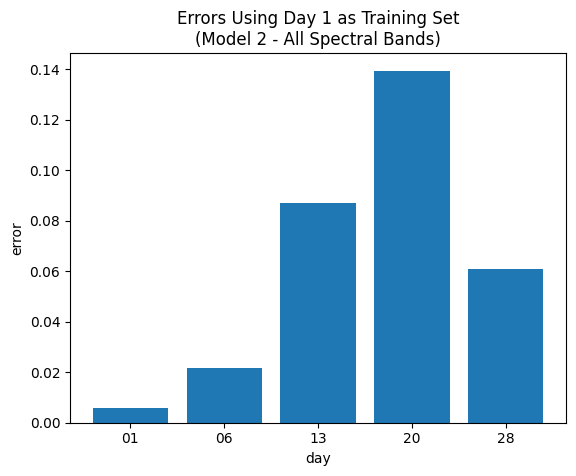

In [31]:
plt.bar(days, errors_model_2)
plt.title(f"Errors Using Day 1 as Training Set\n(Model 2 - All Spectral Bands)")
plt.xlabel("day")
plt.ylabel("error")
plt.show()

## 4. Training on Each Day and Error Calculated on all the Other Days

In [33]:
error_rates = {}
confusion_matrices = {}

for day_training in days:
    # Loading data
    matFile = os.path.join(dirIn, f'multispectral_day{day_training}.mat')
    annFile = os.path.join(dirIn, f'annotation_day{day_training}.png')
    multiIm, annotationIm = hf.loadMulti(matFile, annFile)
    [fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
    [meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);
    [bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);
    mean_fat = np.mean(fatPix, 0)
    mean_meat = np.mean(meatPix, 0)

    # Covariance
    cov_fat = np.cov(fatPix, rowvar=False)
    cov_meat = np.cov(meatPix, rowvar=False)

    # Number of fat and meat pixels
    nf = np.shape(fatPix)[0]
    nm = np.shape(meatPix)[0]
    fat_error_count_total = 0
    meat_error_count_total = 0

    # Pooled Covariance - equation 20
    pooled_cov = ((nf-1)*cov_fat + (nm-1)*cov_meat)/((nf-1)+(nm-1))

    # Discriminant Function - equation 23
    p_fat = nf / (nf + nm)
    p_meat = nm / (nf + nm)
    cov_inv = np.linalg.inv(pooled_cov)

    def Discriminant(x,i): 
        if i == 1: # if fat 
            return x @ cov_inv @ mean_fat - 0.5 * mean_fat  @ cov_inv @ mean_fat  + np.log(p_fat)
        if i == 2: # if meat 
            return x @ cov_inv @ mean_meat - 0.5 * mean_meat @ cov_inv @ mean_meat + np.log(p_meat)

    def Classify(x):
        S_fat = Discriminant(x, 1)
        S_meat = Discriminant(x, 2)
        if S_fat > S_meat:
            return 1 # fat
        else:
            return 2 # meat

    errors_model_2 = []
    for day in days:
        if day == day_training:
            continue
        else:
            # Loading data
            matFile = os.path.join(dirIn, f'multispectral_day{day}.mat')
            annFile = os.path.join(dirIn, f'annotation_day{day}.png')
            multiIm, annotationIm = hf.loadMulti(matFile, annFile)

            [fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
            [meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);
            [bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

            # Classify data based on model 2
            classified = np.zeros(annotationIm.shape[:2], dtype=int)
            for i in range(bgPix.shape[0]):
                r = bgR[i]
                c = bgC[i]
                classified[r, c] = Classify(bgPix[i])

            # Estimate error between classified and annotated data
            nf_day = fatPix.shape[0]
            nm_day = meatPix.shape[0]
            fat_errors = np.sum(Discriminant(fatPix,1) < Discriminant(fatPix,2))
            fat_error_count_total += fat_errors
            meat_errors = np.sum(Discriminant(meatPix,2) < Discriminant(meatPix,1))
            meat_error_count_total += meat_errors
            error = (fat_errors + meat_errors) / (nf_day + nm_day)
            errors_model_2.append(error)

        error_rates[day_training] = errors_model_2

## 5. Analysis

Plotting Error for each Day using each Training Day

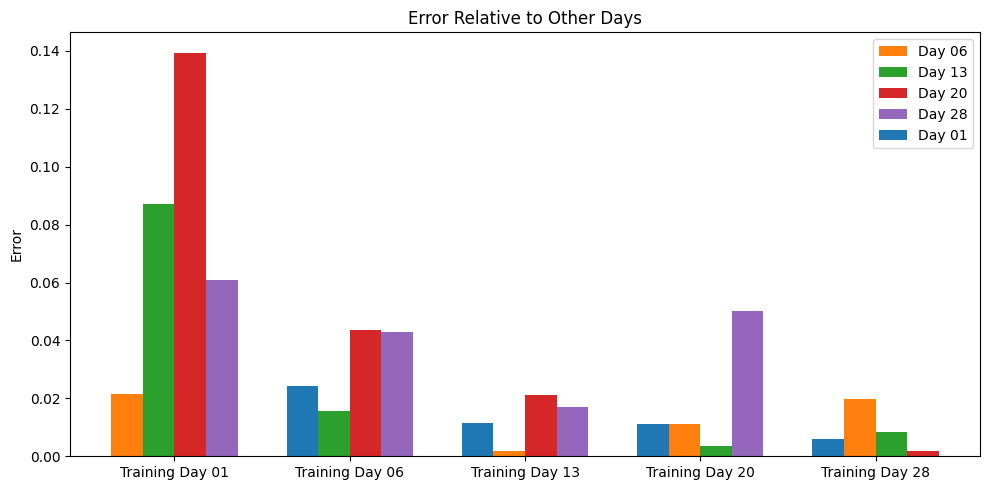

In [18]:
x = np.arange(len(days))
bar_width = 0.18

# fixed color for each comparison day
color_map = {'01': 'C0', '06': 'C1','13': 'C2','20': 'C3','28': 'C4'}

fig, ax = plt.subplots(figsize=(10,5))

legend_added = set()

for i, day in enumerate(days):
    compare_days = [d for d in days if d != day]
    values = error_rates[day]

    n = len(values)
    offsets = np.linspace(-(n-1)/2, (n-1)/2, n) * bar_width

    for off, comp_day, val in zip(offsets, compare_days, values):
        label = f'Day {comp_day}' if comp_day not in legend_added else None

        ax.bar(x[i] + off, val,
               width=bar_width,
               color=color_map[comp_day],
               label=label)

        legend_added.add(comp_day)

ax.set_xticks(x)
ax.set_xticklabels([f'Training Day {d}' for d in days])

ax.set_ylabel("Error")
ax.set_title("Error Relative to Other Days")
ax.legend()

plt.tight_layout()
plt.show()

Plotting Mean Errors

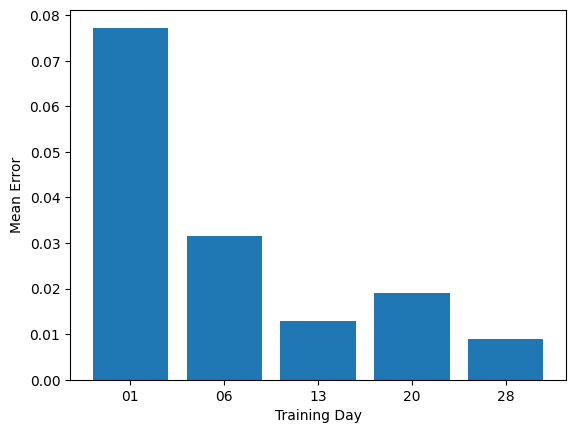

In [34]:
mean_error = {}
for day in error_rates.keys():
    mean_error[day] = np.mean(np.array(error_rates[day]))

plt.bar(days, mean_error.values())
plt.xlabel("Training Day")
plt.ylabel("Mean Error")
plt.show()

## 6. Prior Knowledge

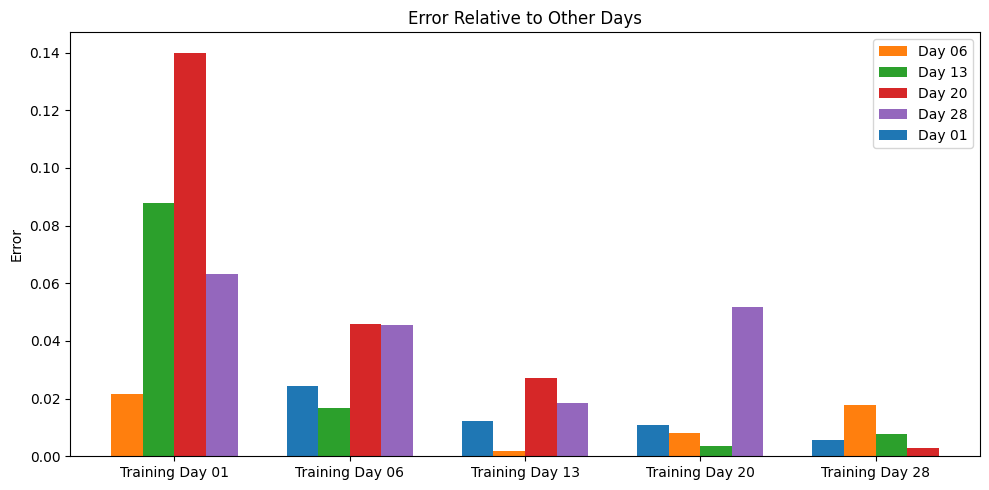

In [35]:
# (1) 
error_rates = {}
confusion_matrices = {}

for day_training in days:
    # Loading data
    matFile = os.path.join(dirIn, f'multispectral_day{day_training}.mat')
    annFile = os.path.join(dirIn, f'annotation_day{day_training}.png')
    multiIm, annotationIm = hf.loadMulti(matFile, annFile)
    [fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
    [meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);
    [bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);
    mean_fat = np.mean(fatPix, 0)
    mean_meat = np.mean(meatPix, 0)

    # Covariance
    cov_fat = np.cov(fatPix, rowvar=False)
    cov_meat = np.cov(meatPix, rowvar=False)

    # Number of fat and meat pixels
    nf = np.shape(fatPix)[0]
    nm = np.shape(meatPix)[0]
    fat_error_count_total = 0
    meat_error_count_total = 0

    # Pooled Covariance - equation 20
    pooled_cov = ((nf-1)*cov_fat + (nm-1)*cov_meat)/((nf-1)+(nm-1))

    # Discriminant Function - equation 23
    p_fat = 0.3 # 30% fat 
    p_meat = 0.7 # 70% meat
    cov_inv = np.linalg.inv(pooled_cov)

    def Discriminant(x,i): 
        if i == 1: # if fat 
            return x @ cov_inv @ mean_fat - 0.5 * mean_fat  @ cov_inv @ mean_fat  + np.log(p_fat)
        if i == 2: # if meat 
            return x @ cov_inv @ mean_meat - 0.5 * mean_meat @ cov_inv @ mean_meat + np.log(p_meat)

    def Classify(x):
        S_fat = Discriminant(x, 1)
        S_meat = Discriminant(x, 2)
        if S_fat > S_meat:
            return 1 # fat
        else:
            return 2 # meat

    errors_model_2 = []
    for day in days:
        if day == day_training:
            continue
        else:
            # Loading data
            matFile = os.path.join(dirIn, f'multispectral_day{day}.mat')
            annFile = os.path.join(dirIn, f'annotation_day{day}.png')
            multiIm, annotationIm = hf.loadMulti(matFile, annFile)

            [fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
            [meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);
            [bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

            # Classify data based on model 2
            classified = np.zeros(annotationIm.shape[:2], dtype=int)
            for i in range(bgPix.shape[0]):
                r = bgR[i]
                c = bgC[i]
                classified[r, c] = Classify(bgPix[i])

            # Estimate error between classified and annotated data
            nf_day = fatPix.shape[0]
            nm_day = meatPix.shape[0]
            fat_errors = np.sum(Discriminant(fatPix,1) < Discriminant(fatPix,2))
            fat_error_count_total += fat_errors
            meat_errors = np.sum(Discriminant(meatPix,2) < Discriminant(meatPix,1))
            meat_error_count_total += meat_errors
            error = (fat_errors + meat_errors) / (nf_day + nm_day)
            errors_model_2.append(error)

        error_rates[day_training] = errors_model_2

# (2)
x = np.arange(len(days))
bar_width = 0.18

# fixed color for each comparison day
color_map = {'01': 'C0', '06': 'C1','13': 'C2','20': 'C3','28': 'C4'}

fig, ax = plt.subplots(figsize=(10,5))

legend_added = set()

for i, day in enumerate(days):
    compare_days = [d for d in days if d != day]
    values = error_rates[day]

    n = len(values)
    offsets = np.linspace(-(n-1)/2, (n-1)/2, n) * bar_width

    for off, comp_day, val in zip(offsets, compare_days, values):
        label = f'Day {comp_day}' if comp_day not in legend_added else None

        ax.bar(x[i] + off, val,
               width=bar_width,
               color=color_map[comp_day],
               label=label)

        legend_added.add(comp_day)

ax.set_xticks(x)
ax.set_xticklabels([f'Training Day {d}' for d in days])

ax.set_ylabel("Error")
ax.set_title("Error Relative to Other Days")
ax.legend()

plt.tight_layout()
plt.show()